<a href="https://colab.research.google.com/github/hdfeos/zoo/blob/master/NSIDC/MOD10C1.A2005018.006.2016141204712.hdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdal
import os
import re
import pyproj
import numpy as np
!pip install matplotlib
# from pydap.client import open_url, open_dods
import matplotlib as mpl
import matplotlib.pyplot as plt


In [7]:
# !apt install proj-bin libproj-dev libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/v1.2.0rel.tar.gz

from mpl_toolkits.basemap import Basemap
import numpy as np
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
FILE_NAME = 'MOD10C1.A2005018.006.2016141204712.hdf'
GRID_NAME = 'MOD_CMG_Snow_5km'
DATAFIELD_NAME = 'Day_CMG_Snow_Cover'

gname = 'HDF4_EOS:EOS_GRID:"{0}":{1}:{2}'.format(FILE_NAME,
                                                 GRID_NAME,
                                                 DATAFIELD_NAME)
gdset = gdal.Open(gname)
data = gdset.ReadAsArray()
        
# Read projection parameters.
x0, xinc, _, y0, _, yinc = gdset.GetGeoTransform()
nx, ny = (gdset.RasterXSize, gdset.RasterYSize)
del gdset



Saving MOD10C1.A2005018.006.2016141204712.hdf to MOD10C1.A2005018.006.2016141204712.hdf
User uploaded file "MOD10C1.A2005018.006.2016141204712.hdf" with length 4759890 bytes


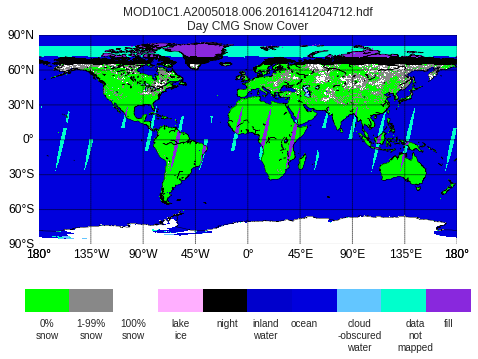

In [8]:
    # Construct the grid.  It's already in lat/lon.
    x = np.linspace(x0, x0 + xinc*nx, nx)
    y = np.linspace(y0, y0 + yinc*ny, ny)
    lon, lat = np.meshgrid(x, y)

    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-90, urcrnrlat = 90,
                llcrnrlon=-180, urcrnrlon = 180)
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180, 180., 45.), labels=[0, 0, 0, 1])

    # Bin the data as follows:
    # 0% snow
    # 1-99% snow
    # 100% snow
    # lake ice (107)
    # night (111)
    # inland water (237)
    # ocean (239)
    # cloud-obscured water (250)
    # data not mapped (253)
    # fill (255)
    lst = ['#00ff00', # 0% snow
           '#888888', # 1-99% snow
           '#ffffff', # 100% snow
           '#ffafff', # lake ice
           '#000000', # night
           '#0000cc', # inland water
           '#0000dd', # ocean
           '#63c6ff', # cloud-obscured water
           '#00ffcc', # data not mapped
           '#8928dd'] # fill
    cmap = mpl.colors.ListedColormap(lst)
    bounds = [0, 1, 100, 107, 111, 237, 239, 250, 253, 255, 256]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    # Render the image in the projected coordinate system.
    m.pcolormesh(lon[::2,::2], lat[::2,::2], data[::2,::2],
                 latlon=True, cmap=cmap, norm=norm)

    long_name = 'Day CMG Snow Cover'
    basename = os.path.basename(FILE_NAME)
    plt.title('{0}\n{1}'.format(basename, long_name))
    fig = plt.gcf()

    color_bar = plt.colorbar(orientation='horizontal')
    color_bar.set_ticks([0.5, 50, 103, 109, 180, 237.8, 242, 251.5, 254.5, 255.5])
    color_bar.set_ticklabels(['0%\nsnow', '1-99%\nsnow', '100%\nsnow', 'lake\nice',
                              'night', 'inland\nwater', 'ocean',
                              'cloud\n-obscured\nwater', 'data\nnot\nmapped',
                              'fill'])
    color_bar.draw_all()

    pngfile = "{0}.py.png".format(basename)
    fig.savefig(pngfile)